# Magnetic inversion on a Tensor Mesh

In [4]:
"""
Load packages
================================
"""

from discretize import TensorMesh
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
)
import discretize
from SimPEG import utils
from SimPEG.utils import mkvc

from discretize.utils import mesh_builder_xyz, refine_tree_xyz
from SimPEG.potential_fields import magnetics
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt


## Model Setup

Define the survey and model parameters

First we need to define the direction of the inducing field
As a simple case, we pick a vertical inducing field

In [71]:
# Ambient field parameters
D = 1.540833
I = -68.3075
H = 49677.8

# We will assume a vertical inducing field
H0 = (H, I, D)

# The magnetization is set along a different direction (induced + remanence)
M1 = np.array([69.0, -74.0])
M2 = np.array([69.0, -74.0])
M3 = np.array([69.0, -74.0])

MB = np.array([0.001, 0.001])

# let import the mesh in UBC format
mesh_file = r"C:\Users\johnk\Documents\git\jresearch\PGI\qmagt\simulation_inputs\shallow_water_sus.msh"
mesh = discretize.TensorMesh.readUBC(mesh_file)

# load the conductivity model
susceptibity_file = r"C:\Users\johnk\Documents\git\jresearch\PGI\qmagt\simulation_inputs\shallow_water_sus.mod"
model = discretize.TensorMesh.readModelUBC(mesh, susceptibity_file)

actinds = model > 1e-8

## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

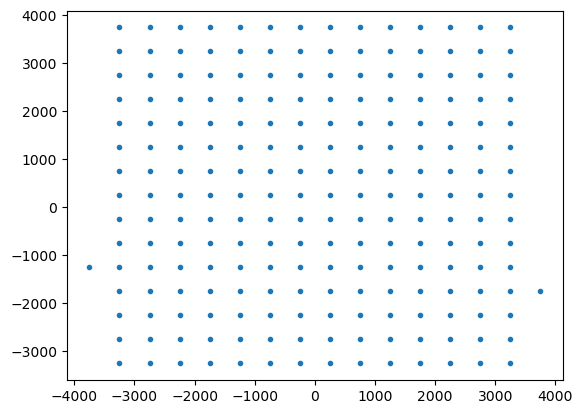

In [72]:
# process the receivers
receivers = np.genfromtxt(r"C:\Users\johnk\Documents\git\jresearch\PGI\mt\simulation_inputs\stations.csv", delimiter=',', skip_header=1)

receivers[:, 0] = receivers[:, 0] - 2250
receivers[:, 1] = receivers[:, 1] - 2250

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


## Create a MAGsurvey SimPEG object

accepted components = 'bxx', 'bxy', 'bxz', 'byy', 'byz', 'bzz', 'tmi', 'bx', 'by', 'bz'

In [73]:
xyzLoc = np.c_[mkvc(receivers[:, 0].T), mkvc(receivers[:, 1].T), mkvc(receivers[:, 2].T)]
rxLoc = magnetics.receivers.Point(xyzLoc, components=['bxx', 'bxy', 'bxz', 'byy', 'byz', 'bzz', 'tmi'])
srcField = magnetics.sources.SourceField(receiver_list=[rxLoc], parameters=H0)
survey = magnetics.survey.Survey(srcField)


## Break the sus model down into its magnetization vector

Here we can do fancy stuff like play with remanence

In [74]:
susceptability_model = np.zeros((mesh.nC, 3))
MB_xyz = utils.mat_utils.dip_azimuth2cartesian(H0[1], H0[2])
print(susceptability_model[actinds, :].shape, np.ones((actinds.sum(), 1)).shape, (MB_xyz * bckgr).shape)

susceptability_model = np.zeros((mesh.nC, 3)) + 1e-8
MB_xyz = utils.mat_utils.dip_azimuth2cartesian(H0[1], H0[2])

print(susceptability_model[actinds, :].shape, model[actinds].shape, MB_xyz.shape)

susceptability_model[actinds, :] = np.kron(np.reshape(model[actinds], (actinds.sum(), 1)), MB_xyz)

# now lets do the remanence model
remanence_model = np.zeros((mesh.nC, 3)) + 1e-8

# Convert the inclination declination to vector in Cartesian
M1_xyz = utils.mat_utils.dip_azimuth2cartesian(M1[0], M1[1])

# Assign magnetization values for inducing field
remanence_model[actinds, :] = np.kron(np.reshape(model[actinds], (actinds.sum(), 1)), M1_xyz)

# Convert the inclination declination to vector in Cartesian
M2_xyz = utils.mat_utils.dip_azimuth2cartesian(M2[0], M2[1])

# Assign magnetization values
remanence_model[actinds, :] = np.kron(np.reshape(model[actinds], (actinds.sum(), 1)), M2_xyz)

plot_model = remanence_model + susceptability_model

# outputs true modelS
discretize.TensorMesh.writeUBC(mesh, 'mvi-simulation-tensor.msh',models={'mvi-simulation-true_model.mod': np.sum(plot_model**2, axis=1)**0.5})

(54872, 3) (54872, 1) (1, 3)
(54872, 3) (54872,) (1, 3)


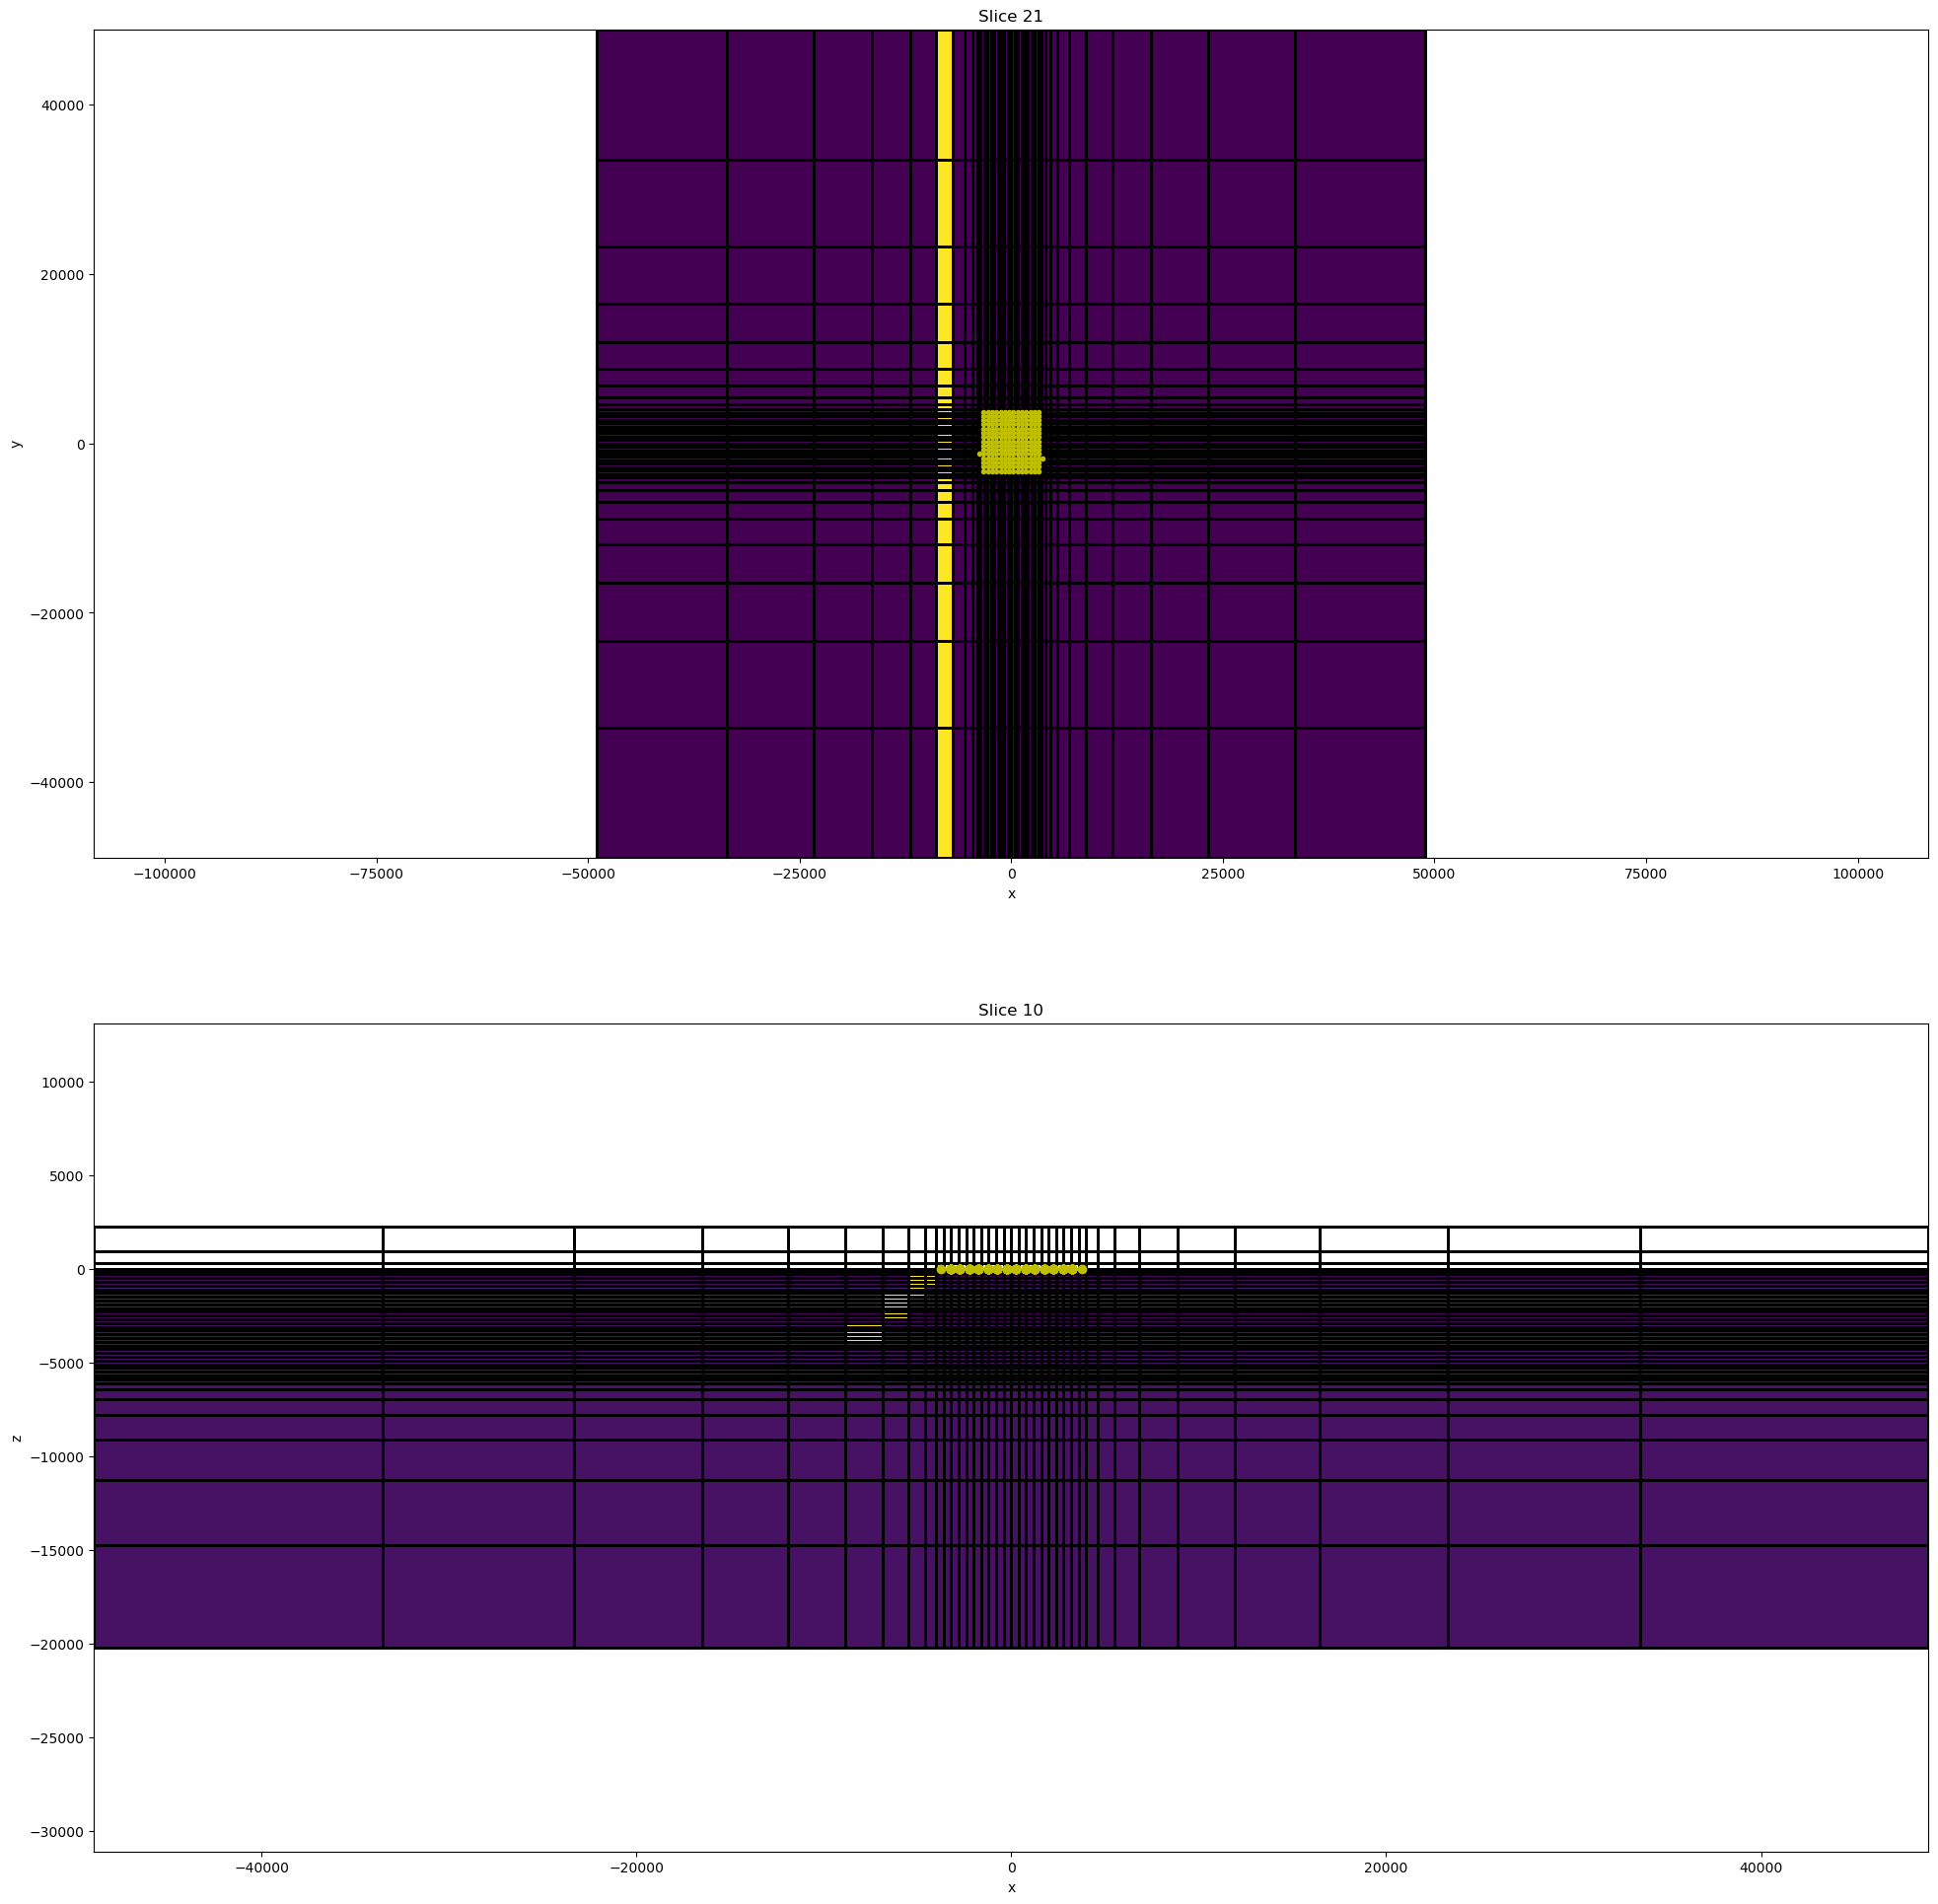

In [75]:
amp = np.sum(plot_model**2, axis=1)**0.5
amp[~actinds] = np.nan
plt.figure(figsize=(24, 24))
ax = plt.subplot(2, 1, 1)
collect_obj = mesh.plotSlice(amp,ax=ax, grid=True, normal='Z')
# color_bar = plt.colorbar(collect_obj)
plt.plot(xyzLoc[:, 0], xyzLoc[:, 1], '.y')
ax.axis('equal')
# plt.ylim([-1000, 1000])

ax1 = plt.subplot(2, 1, 2)
collect_obj = mesh.plotSlice(amp,ax=ax1, grid=True, normal='Y', ind=10)
# color_bar = plt.colorbar(collect_obj)
plt.plot(xyzLoc[:, 0], xyzLoc[:, 2], 'oy')
# plt.ylim([-1000, 1000])
ax1.axis('equal')
plt.show()

## Forward modeling data

In [76]:
model2 = plot_model[actinds, :]
# model2[~actinds, :] = np.log(1e-8)
# Create active map to go from reduce set to full
actvMap = maps.InjectActiveCells(mesh, actinds, valInactive=np.log(1e-8))

# Creat reduced identity map
idenMap = maps.IdentityMap(nP=int(actinds.sum()) * 3)

# Create the simulation
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, chiMap=idenMap, actInd=actinds, model_type="vector"
)

# Compute some data and add some random noise
d = simulation.dpred(mkvc(model2))

std = 0.05  # nT
# noise = np.random.randn(len(d)) * 0.01
# d = d + noise
wd = np.ones(len(d)) * std

data_matrix = d.reshape((xyzLoc.shape[0], int(survey.nD / xyzLoc.shape[0])))

# # assign error to certain components
# comps_ = ['bxx', 'bxy', 'bxz', 'byy', 'byz', 'bzz', 'tmi']
# cnt_comp = 0
# noise = np.random.randn(xyzLoc.shape[0]) * 0.05
# for rx_orientation in range(len(comps_)):
    
#     if comps_[rx_orientation] == 'tmi':
#         print(f"in tmi comp {comps_[rx_orientation]}")
#         data_matrix[:, cnt_comp] = data_matrix[:, cnt_comp] + noise
        
#     elif len(comps_[rx_orientation]) == 2:
#         print(f"in norm comp {comps_[rx_orientation]}")

#         data_matrix[:, cnt_comp] = data_matrix[:, cnt_comp] + noise

        
#     cnt_comp += 1

synthetic_data = np.reshape(data_matrix, survey.nD)
# Assign data and uncertainties to the survey
data_object = data.Data(survey, dobs=synthetic_data, standard_deviation=wd)


## Plot the gradiometry data

(212, 3) 2.703096539162113


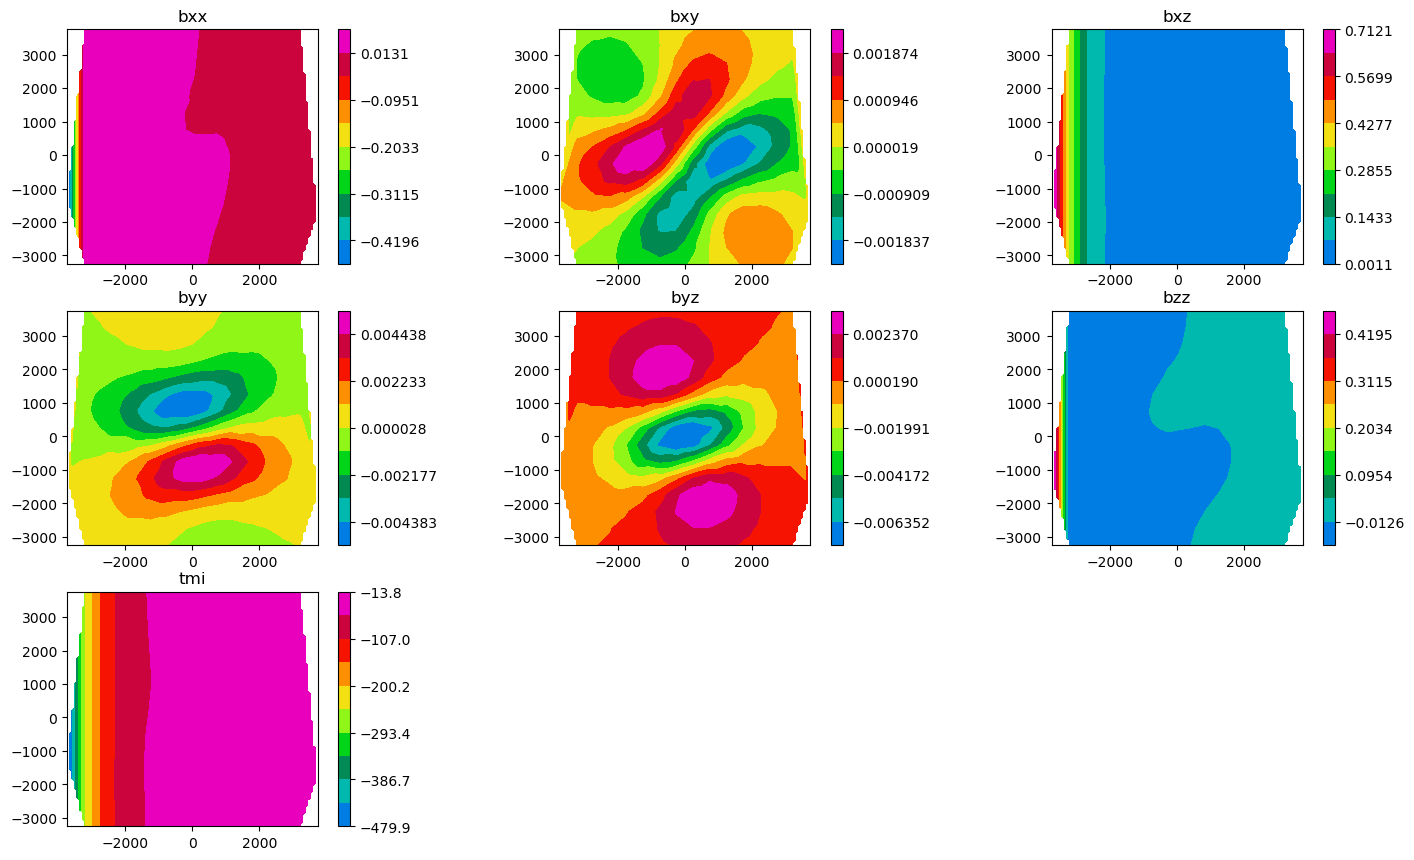

In [77]:
from matplotlib.colors import LinearSegmentedColormap
colors = np.array([[0, 82, 246, 255], [0, 196, 196, 255], [0, 137, 83, 255], [1, 233, 11, 255], [234, 255, 31, 255], [255, 176, 0, 255], [247, 19, 0, 255], [193, 0, 76, 255], [255, 0, 255, 255]])
cmap = LinearSegmentedColormap.from_list('', colors / 255, 256)

# plot some data
comps_ = ['bxx', 'bxy', 'bxz', 'byy', 'byz', 'bzz', 'tmi']
print(xyzLoc.shape, survey.nD / 549)
data_matrix = synthetic_data.reshape((xyzLoc.shape[0], int(survey.nD / xyzLoc.shape[0])))

# data profile holder
comp_profile = []

fig1 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):

    y_ = []
    data_ = []

    for ii in range(xyzLoc.shape[0]):

        if int(xyzLoc[ii, 1]) == -250:
            y_.append(xyzLoc[ii, 0])
            data_.append(data_matrix[ii, cnt_comp])
    comp_profile.append((y_, data_, comps_[rx_orientation]))
    ax = plt.subplot(4,3, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(xyzLoc, data_matrix[:, cnt_comp], ax=ax, contourOpts={'cmap':cmap})
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
plt.show()

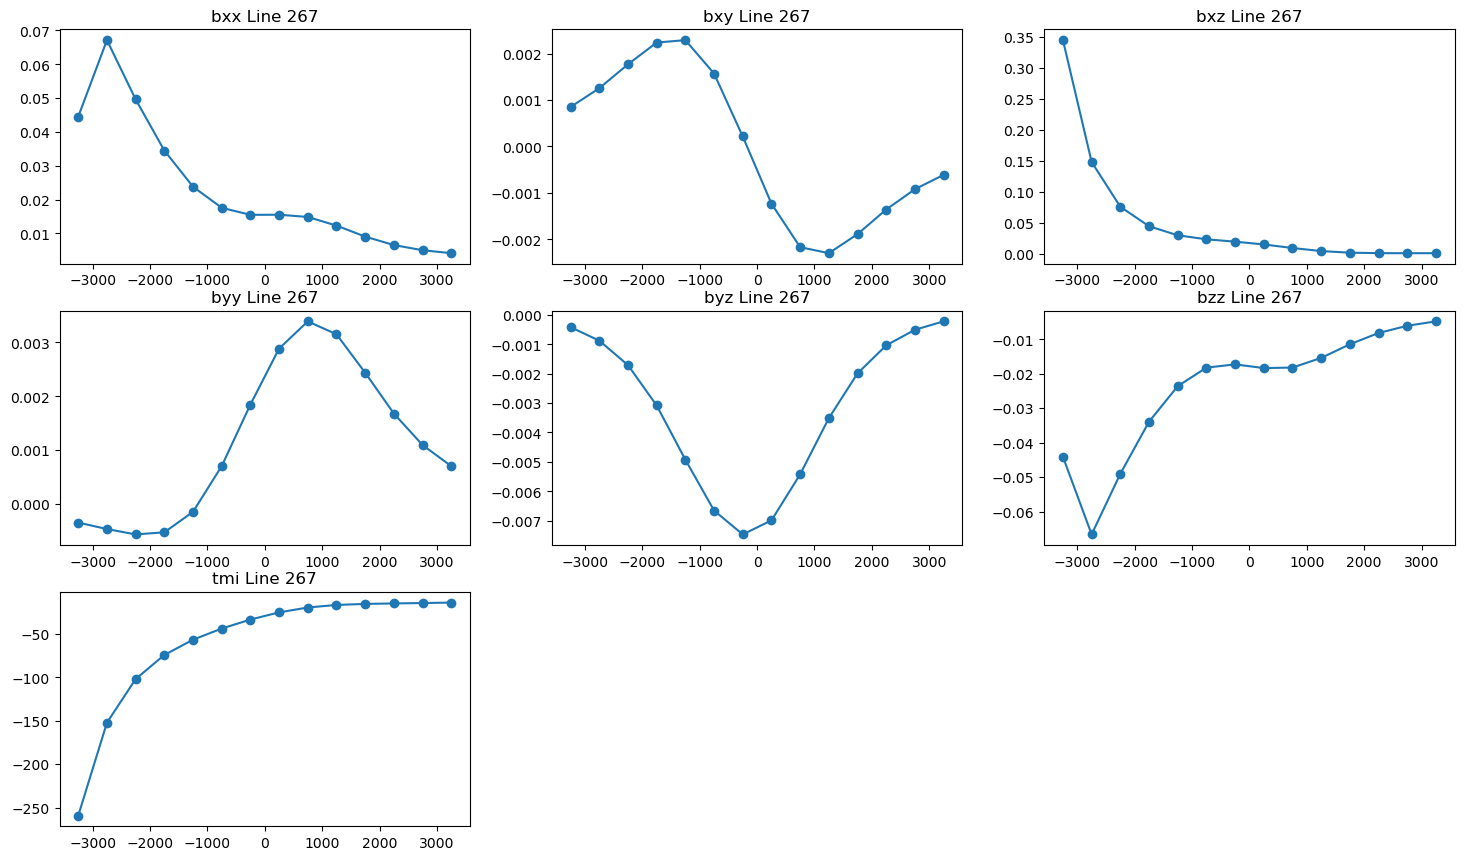

In [78]:

fig1 = plt.figure(figsize=(18, 14))
cnt_comp = 0

for info in comp_profile:

    ax = plt.subplot(4,3, cnt_comp + 1)
    
    ax.plot(info[0], info[1], 'o-')
    ax.set_title(info[-1] + " Line 267")

    cnt_comp += 1
    
plt.show()
    # print(comp_profile[0])

In [9]:
######################################################################
# Inversion
# ---------
#
# We can now attempt the inverse calculations. We put some great care
# in design an inversion methology that would yield geologically
# reasonable solution for the non-induced problem.
# The inversion is done in two stages. First we compute a smooth
# solution using a Cartesian coordinate system, then a sparse
# inversion in the Spherical domain.
#

# Create sensitivity weights from our linear forward operator
rxLoc = survey.source_field.receiver_list[0].locations

# This Mapping connects the regularizations for the three-component
# vector model
wires = maps.Wires(("p", nC), ("s", nC), ("t", nC))

m0 = np.ones(3 * nC) * 1e-4  # Starting model

# Create three regularization for the different components
# of magnetization
reg_p = regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.mref = np.zeros(3 * nC)

reg_s = regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.mref = np.zeros(3 * nC)

reg_t = regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.mref = np.zeros(3 * nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3 * nC)

# Data misfit function
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / data_object.standard_deviation

# Add directives to the inversion
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-10, upper=10.0, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)

# A list of directive to control the inverson
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# Here is where the norms are applied
# Use pick a threshold parameter empirically based on the distribution of
#  model parameters
IRLS = directives.Update_IRLS(f_min_change=1e-3, max_irls_iterations=2, beta_tol=5e-1)

# Pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()

inv = inversion.BaseInversion(
    invProb, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest]
)

# Run the inversion
mrec_MVIC = inv.run(m0)



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.33e+13  1.41e+06  2.64e-05  3.52e+08    7.15e+03      0              
   1  6.63e+12  1.38e+06  2.64e-05  1.77e+08    7.14e+03      0              
   2  3.32e+12  1.12e+06  1.88e-08  1.18e+06    7.14e+03      0   Skip BFGS  
   3  1.66e+12  9.45e+05  5.76e-08  1.04e+06    7.13e+03      0   Skip BFGS  
   4  8.29e+11  7.31e+05  1.51e-07  8.56e+05    7.13e+03      0   Skip BFGS  
   5  4.15e+11  5.11e+05  3.41e-07  6.53e+05    7.12e+03      0   Skip BFGS  
   6  2.07e+11  3.23e+05  6.65e-07  4.61e+05    7.10e+03      0   Skip BFGS  
   7  1.04e+11  1.85e+05  1.13e-06

In [10]:
def xyz2pst(m, param):
    """
    Rotates from cartesian to pst
    pst coordinates along the primary field H0
    INPUT:
        m : nC-by-3 array for [x,y,z] components
        param: List of parameters [A, I, D] as given by survey.SrcList.param
    """

    nC = int(len(m)/3)

    Rz = np.vstack((np.r_[np.cos(np.deg2rad(-param[2])),
                          -np.sin(np.deg2rad(-param[2])), 0],
                   np.r_[np.sin(np.deg2rad(-param[2])),
                         np.cos(np.deg2rad(-param[2])), 0],
                   np.r_[0, 0, 1]))

    Rx = np.vstack((np.r_[1, 0, 0],
                   np.r_[0, np.cos(np.deg2rad(-param[1])),
                         -np.sin(np.deg2rad(-param[1]))],
                   np.r_[0, np.sin(np.deg2rad(-param[1])),
                         np.cos(np.deg2rad(-param[1]))]))

    yvec = np.c_[0, 1, 0]
    pvec = np.dot(Rz, np.dot(Rx, yvec.T))

    xvec = np.c_[1, 0, 0]
    svec = np.dot(Rz, np.dot(Rx, xvec.T))

    zvec = np.c_[0, 0, 1]
    tvec = np.dot(Rz, np.dot(Rx, zvec.T))

    m_pst = np.r_[np.dot(pvec.T, m.T),
                  np.dot(svec.T, m.T),
                  np.dot(tvec.T, m.T)].T

    return m_pst


def pst2xyz(m, param):
    """
    Rotates from pst to cartesian
    pst coordinates along the primary field H0
    INPUT:
        m : nC-by-3 array for [x,y,z] components
        param: List of parameters [A, I, D] as given by survey.SrcList.param
    """

    nC = int(len(m)/3)

    Rz = np.vstack((np.r_[np.cos(np.deg2rad(-param[2])),
                          -np.sin(np.deg2rad(-param[2])), 0],
                   np.r_[np.sin(np.deg2rad(-param[2])),
                         np.cos(np.deg2rad(-param[2])), 0],
                   np.r_[0, 0, 1]))

    Rx = np.vstack((np.r_[1, 0, 0],
                   np.r_[0, np.cos(np.deg2rad(-param[1])),
                         -np.sin(np.deg2rad(-param[1]))],
                   np.r_[0, np.sin(np.deg2rad(-param[1])),
                         np.cos(np.deg2rad(-param[1]))]))

    yvec = np.c_[0, 1, 0]
    pvec = np.dot(Rz, np.dot(Rx, yvec.T))

    xvec = np.c_[1, 0, 0]
    svec = np.dot(Rz, np.dot(Rx, xvec.T))

    zvec = np.c_[0, 0, 1]
    tvec = np.dot(Rz, np.dot(Rx, zvec.T))

    pst_mat = np.c_[pvec, svec, tvec]

    m_xyz = np.dot(m, pst_mat.T)

    return m_xyz

In [11]:
print(survey.nD, mesh.nC)

9801 170368


In [12]:
nC = int(actv.sum())
# create the extracted info
vec_xyz = opt.xc
atp = utils.mat_utils.cartesian2spherical(opt.xc.reshape((int(len(opt.xc)/3), 3), order='F'))
theta = atp[nC:2*nC]
phi = atp[2*nC:]

vec_x = vec_xyz[:nC]
vec_y = vec_xyz[nC:2*nC]
vec_z = vec_xyz[2*nC:]

vec = np.c_[vec_x, vec_y, vec_z]

m_pst = xyz2pst(
    vec, simulation.survey.source_field.parameters
)
m_ind = m_pst.copy()
m_ind[:, 1:] = 0.
m_ind = pst2xyz( m_ind, simulation.survey.source_field.parameters)

m_rem = m_pst.copy()
m_rem[:, 0] = 0.
m_rem = pst2xyz(m_rem, simulation.survey.source_field.parameters)

# build model for m_rem
rem_model = np.ones(mesh.nC) * 1e-8
rem_model[actv] = np.sum(m_rem**2, axis=1)**0.5

# build model for m_ind
ind_model = np.ones(mesh.nC) * 1e-8
ind_model[actv] = np.sum(m_ind**2, axis=1)**0.5

# build model for tot
tot_model = np.ones(mesh.nC) * 1e-8
tot_model[actv] = np.sum(vec**2, axis=1)**0.5

# build model for dip
dip_model = np.ones(mesh.nC) * 1e-8
dip_model[actv] = (np.rad2deg(theta))

# build model for azm
azm_model = np.ones(mesh.nC) * 1e-8
azm_model[actv] = ((450 - np.rad2deg(phi)) % 360)

fileName = 'mvi-simulation-v3-bxyz'
# TreeMesh.writeUBC(mesh, 'mvi-simulation-OctreeMesh.msh',models={'mvi-simulation-v2_REM.mod': rem_model})
discretize.TensorMesh.writeUBC(mesh,
fileName + '.msh',
models={
    fileName + '.dip': dip_model,
    fileName + '.azm': azm_model,
    fileName + '_TOT.mod': tot_model,
    fileName + '_IND.mod': ind_model,
    fileName + '_REM.mod': rem_model})

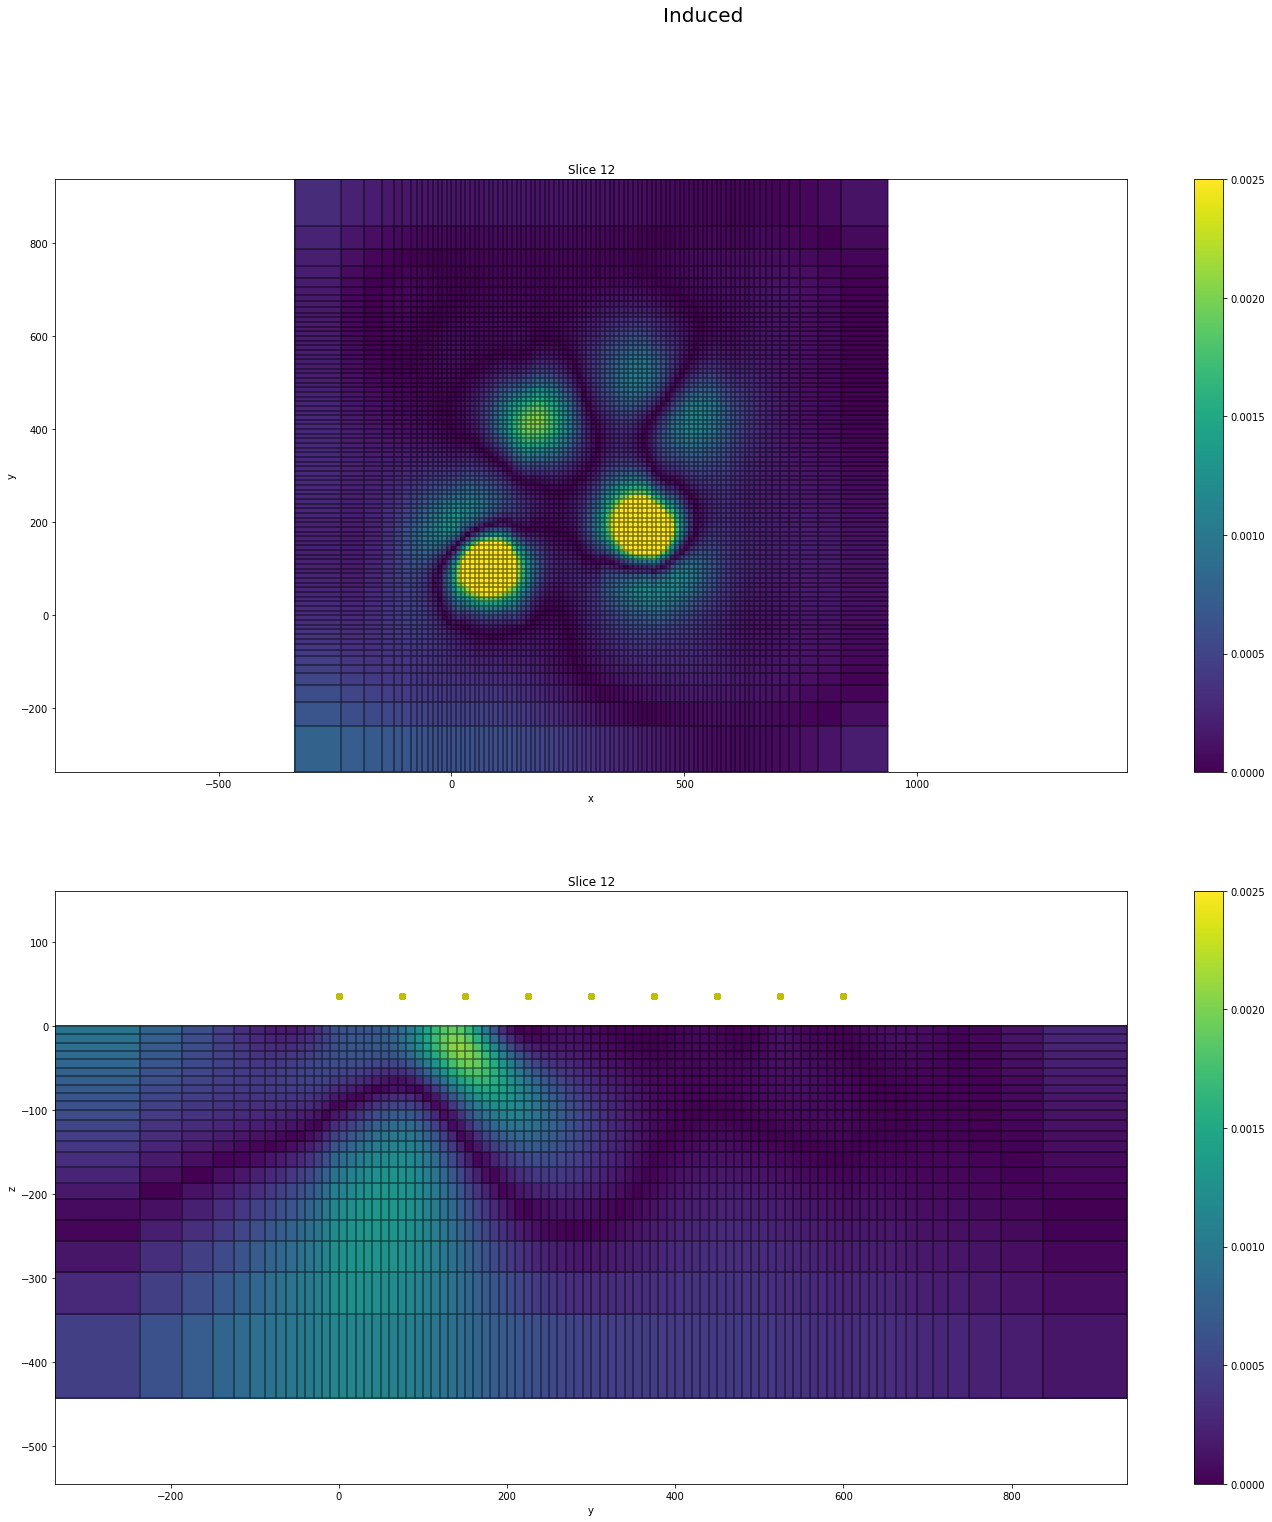

In [13]:
ncx = int(np.searchsorted(mesh.vectorCCx, np.mean(xyzLoc[:,0]) ))
ncy = int(np.searchsorted(mesh.vectorCCy, np.mean(xyzLoc[:,1]) ))
ncz = int(np.searchsorted(mesh.vectorCCz, np.mean(xyzLoc[:,2]) ))
clim = [0, 0.0025]
amp = ind_model
amp[~actv] = np.nan
plt.figure(figsize=(24, 24))
plt.suptitle('Induced', fontsize=20)
ax = plt.subplot(2, 1, 1)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='Z')
color_bar = plt.colorbar(collect_obj)
ax.axis('equal')
# plt.plot(xyzLoc[:, 0], xyzLoc[:, 1], 'oy')
# plt.ylim([-1000, 1000])

ax1 = plt.subplot(2, 1, 2)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax1, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='X')
color_bar = plt.colorbar(collect_obj)
plt.plot(xyzLoc[:, 0], xyzLoc[:, 2], 'oy')
# plt.ylim([-1000, 1000])
ax1.axis('equal')
plt.show()

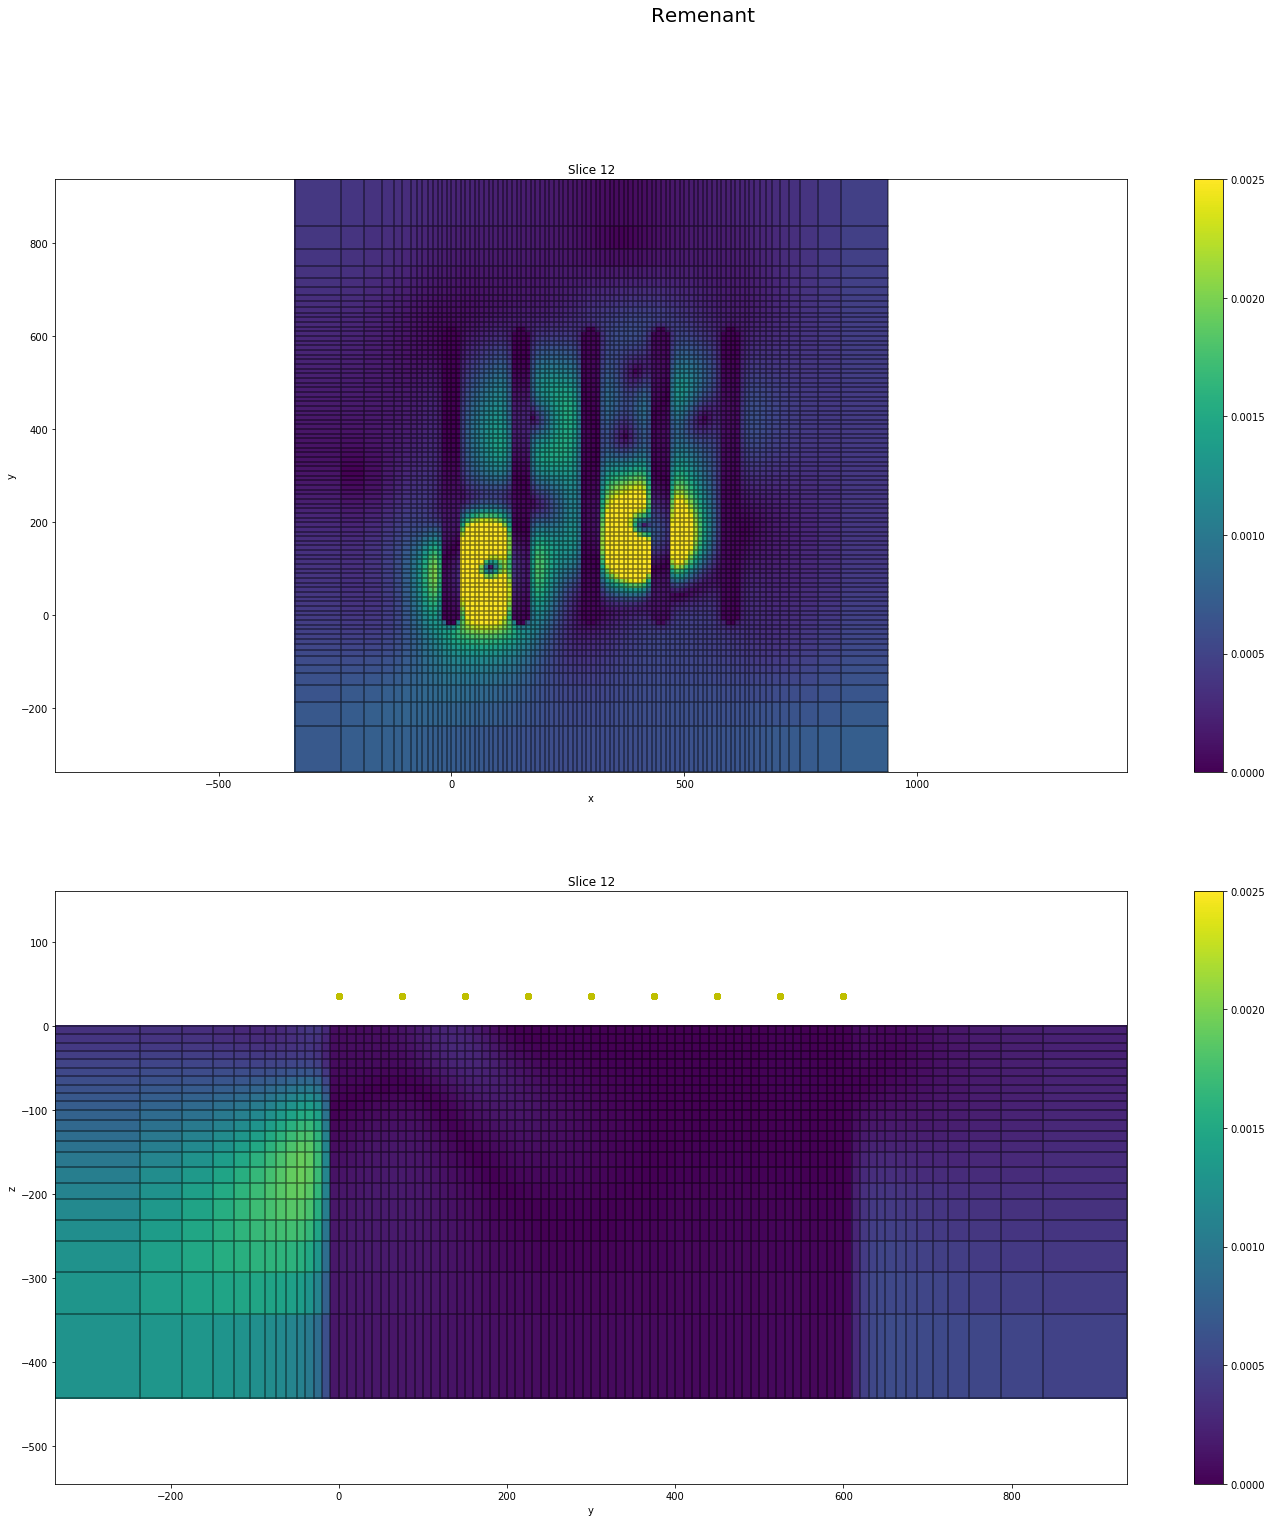

In [14]:
amp = rem_model
amp[~actv] = np.nan
plt.figure(figsize=(24, 24))
plt.suptitle('Remenant', fontsize=20)
ax = plt.subplot(2, 1, 1)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='Z')
color_bar = plt.colorbar(collect_obj)
ax.axis('equal')
# plt.plot(xyzLoc[:, 0], xyzLoc[:, 1], 'oy')
# plt.ylim([-1000, 1000])

ax1 = plt.subplot(2, 1, 2)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax1, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='X')
color_bar = plt.colorbar(collect_obj)
plt.plot(xyzLoc[:, 0], xyzLoc[:, 2], 'oy')
# plt.ylim([-1000, 1000])
ax1.axis('equal')
plt.show()

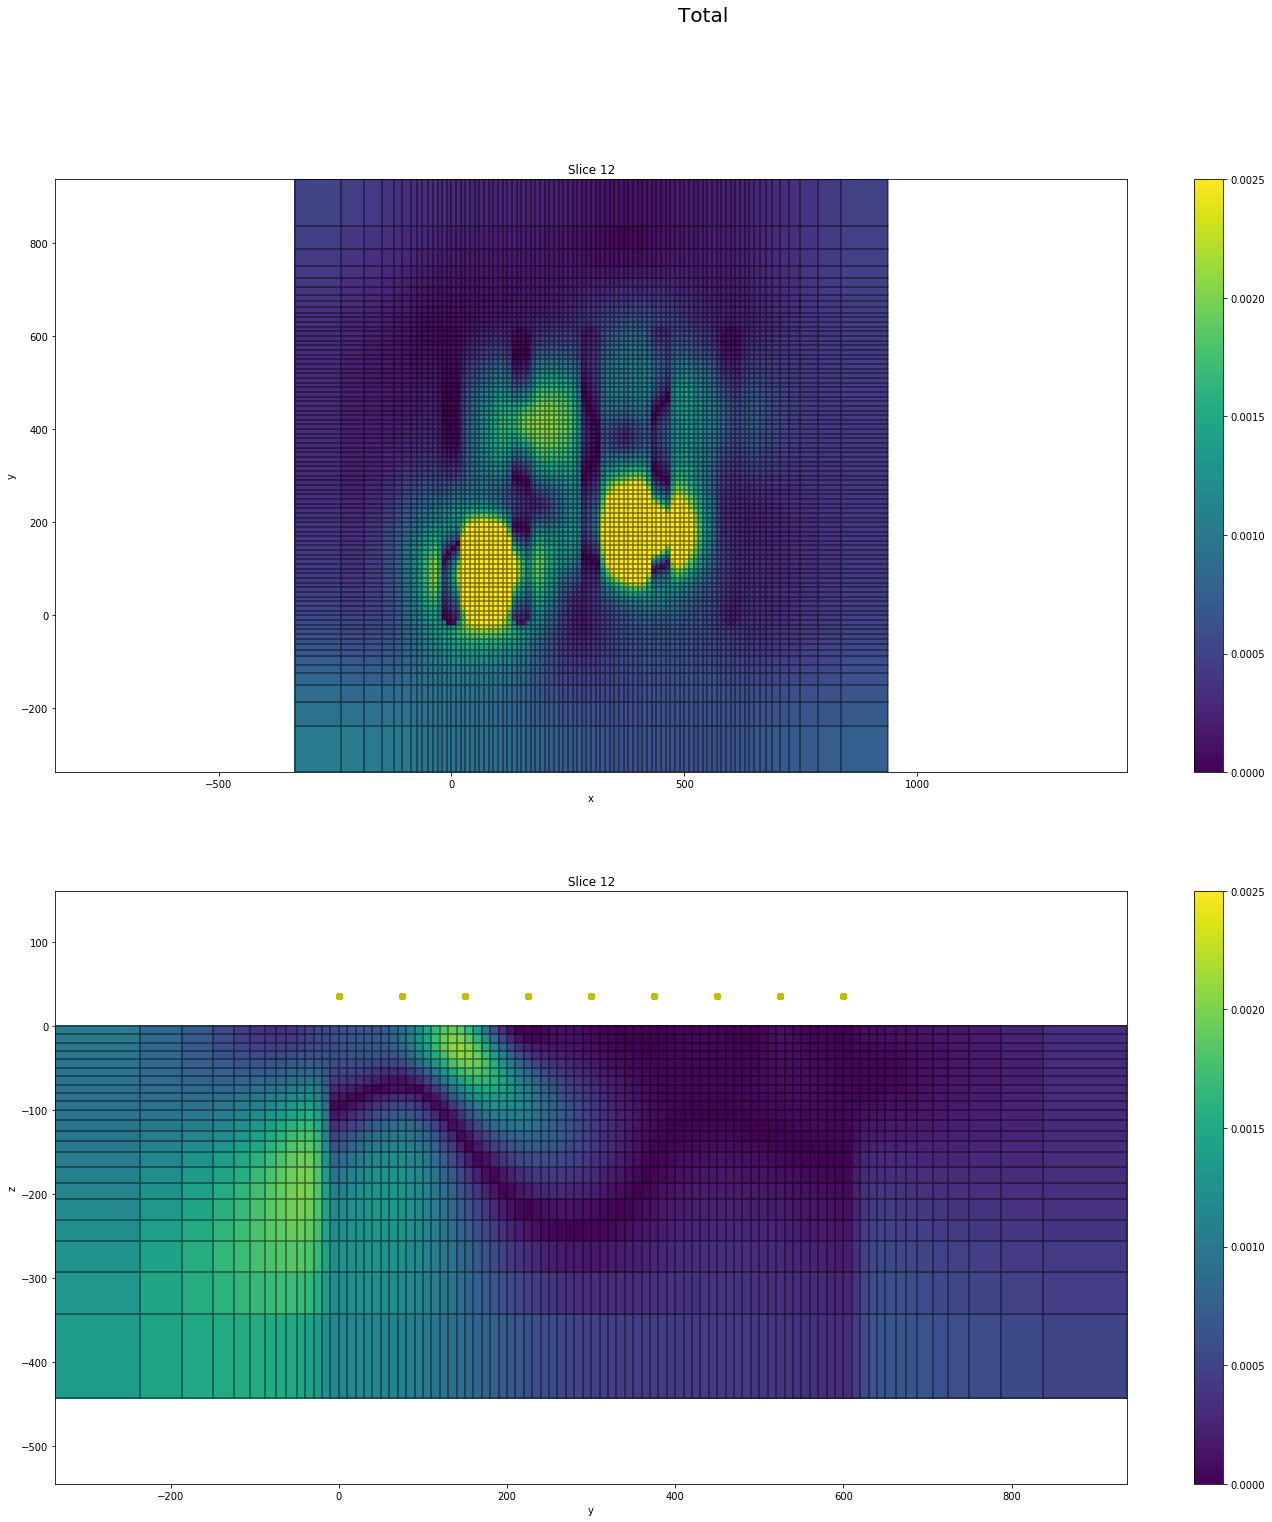

In [15]:
amp = tot_model
amp[~actv] = np.nan
plt.figure(figsize=(24, 24))
plt.suptitle('Total', fontsize=20)
ax = plt.subplot(2, 1, 1)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='Z')
color_bar = plt.colorbar(collect_obj)
ax.axis('equal')
# plt.plot(xyzLoc[:, 0], xyzLoc[:, 1], 'oy')
# plt.ylim([-1000, 1000])

ax1 = plt.subplot(2, 1, 2)
collect_obj, line_obj = mesh.plotSlice(amp,ax=ax1, clim=clim,
                             ind=int(ncz - 10), grid=True, normal='X')
color_bar = plt.colorbar(collect_obj)
plt.plot(xyzLoc[:, 0], xyzLoc[:, 2], 'oy')
# plt.ylim([-1000, 1000])
ax1.axis('equal')
plt.show()